<h1 align = "center"> MSU-NIST </h1>

## CS:3210 Machine Learning Final Project
### Professor: Feng Jiang 


#### Team Members:
* **Ling Thang**
* **Joaquin Trujillo**

#### Project Description:
For our Final project we have decided to work on the classic digit recognition problem. Taking a spin on the classic MNSIT dataset we have decided to collect our own dataset from study around the Auraria campus housing the three schools MSU Denver, CU Denver, and CCD. We decided to take this approach because we believe that as machine learning students it is not only important to understand not just the application of machine learning but also the data collection, cleaning, and preprocessing that goes into it. We believe that this will give us a better understanding of the process and the challenges that come with it as well as the importance of data quality.

In [17]:
# Standard library imports
import os
from PIL import Image

# Third-party library imports
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Naigate to the folder and create classes for Digit Recognition

In [18]:
data_dir = 'Data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

print(sorted(classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Preprocessing the data 

## create two arrays X and y

## Loop through the 

In [19]:
# Create empty np arrays to store the images and labels
X = []
y = []

# Loop through the classes
for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    
    # print the number of files in each class
    print(f'{c}: {len(files)}')

    # Loop through the images
    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        
        # Check if image is RGBA, if not, handle it
        if img.mode != 'RGBA':
            print(f"Skipping {f}: Not an RGBA image")
            continue
        
        # Convert RGBA image to RGB
        img = img.convert('RGB')
        
        # Convert RGB image to grayscale
        gray_img = img.convert('L')
        
        # Resize to (28, 28)
        gray_img = gray_img.resize((28, 28))
        
        # Convert to numpy array
        gray_img = np.array(gray_img)
        
        # Expand dimensions to make it (28, 28, 1)
        gray_img = np.expand_dims(gray_img, axis=-1)
        
        # Normalize pixel values to range [0, 1]
        gray_img = gray_img / 255.0
        
        # Append to the list of images and labels
        X.append(gray_img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

print(X.shape)


9: 100
0: 100
7: 100
6: 100
1: 100
8: 100
4: 100
3: 100
2: 100
5: 100
(1000, 28, 28, 1)


In [20]:
# print the shape of the arrays
print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Save the data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('classes.npy', classes)

#print('Data saved')
print('X_train shape:', X_train.shape)
print (y_train.shape)


(1000, 28, 28, 1)
(1000,)
X_train shape: (800, 28, 28, 1)
(800, 10)


In [21]:
# Load the data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy')

print('Data loaded')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(sorted(classes))



Data loaded
(800, 28, 28, 1)
(200, 28, 28, 1)
(800, 10)
(200, 10)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


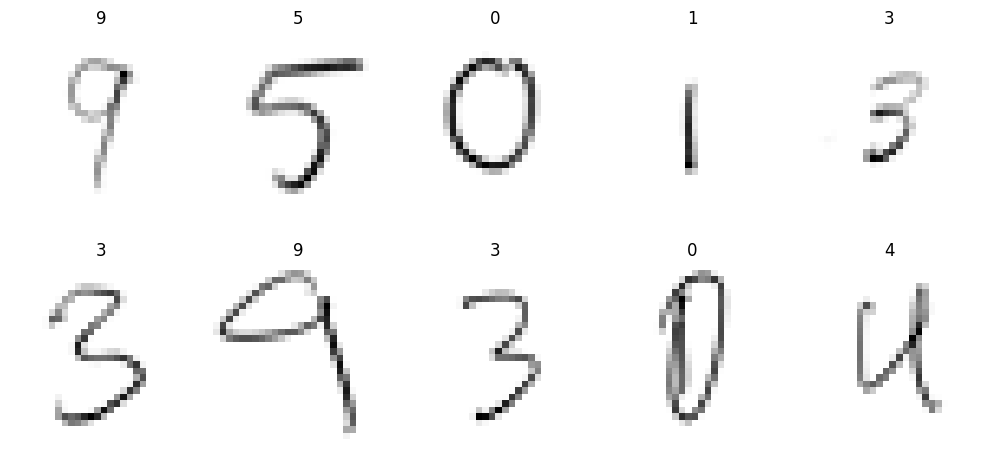

In [22]:
# print a random sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx], cmap = "gray")
    axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# data augmentation
datagen = ImageDataGenerator(
      #rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

augmented_X = []
augmented_y = []

def balance_dataset(X, y):
    balanced_X = []
    balanced_y = []
    num_classes = y.shape[1]
    for c in range(num_classes):
        indices = [i for i, label in enumerate(y) if np.argmax(label) == c]
        print(f"Class {c}: {len(indices)} samples")
        if len(indices) < 1:
            continue  # Skip if the class has no samples
        num_samples_per_class = min(np.sum([1 for label in y if np.argmax(label) == c]), len(indices))
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=True)
        balanced_X.extend([X[i] for i in selected_indices])
        balanced_y.extend([y[i] for i in selected_indices])
    return balanced_X, np.array(balanced_y)

# Balance the dataset
balanced_X_train, balanced_y_train = balance_dataset(X_train, y_train)
print("Number of samples in balanced dataset:", len(balanced_X_train))

# Now, apply data augmentation to the balanced dataset
# Generate augmented data for each sample in the balanced dataset
for i in range(len(balanced_X_train)):
    X_train_example = balanced_X_train[i].reshape((1, 28, 28, 1))
    y_train_example = balanced_y_train[i].reshape((1, 10))  # Reshape to (1, 10) as it's one-hot encoded
    num_augmented_samples = 10  # You can adjust the number of augmented samples per original sample
    for _ in range(num_augmented_samples):
        X_train_augmented, y_train_augmented = datagen.flow(X_train_example, y_train_example).__next__()
        # Reshape augmented data to remove extra dimension
        X_train_augmented = X_train_augmented.squeeze(axis=0)
        y_train_augmented = y_train_augmented.squeeze(axis=0)
        augmented_X.append(X_train_augmented)
        augmented_y.append(y_train_augmented)

# Convert lists to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Print the shape of the augmented dataset
print("Shape of augmented dataset:", augmented_X.shape)
print("Shape of augmented labels:", augmented_y.shape)
print("Number of classes:", len(classes))
print("Number of unique classes in y_train:", len(np.unique(np.argmax(y_train, axis=1))))
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Class 0: 80 samples
Class 1: 80 samples
Class 2: 80 samples
Class 3: 80 samples
Class 4: 80 samples
Class 5: 80 samples
Class 6: 80 samples
Class 7: 80 samples
Class 8: 80 samples
Class 9: 80 samples
Number of samples in balanced dataset: 800
Shape of augmented dataset: (8000, 28, 28, 1)
Shape of augmented labels: (8000, 10)
Number of classes: 10
Number of unique classes in y_train: 10
Shape of X_train: (800, 28, 28, 1)
Shape of y_train: (800, 10)


In [24]:
for i, c in enumerate(classes):
    print(f'{c}: {np.sum(np.argmax(augmented_y, axis=1) == i)}')

9: 800
0: 800
7: 800
6: 800
1: 800
8: 800
4: 800
3: 800
2: 800
5: 800


In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


def intialize_model_train(model,epoch, batch_size):
	print("******* training network *******")
# Compile the model with Adam optimizer
	adam_optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
	model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
	# go through the data 5 times with 128 batch sizes
	H = model.fit(augmented_X,augmented_y, validation_data=(X_test, y_test),
		epochs=epoch, batch_size=batch_size)

	# evaluate the network
	print("******* evaluating network *******")
	predictions = model.predict(X_test, batch_size=batch_size)
	print(classification_report(y_test.argmax(axis=1),
		predictions.argmax(axis=1)))

In [26]:
intialize_model_train(model,9,100)

******* training network *******
Epoch 1/9
80/80 [==============================] - 13s 148ms/step - loss: 2.3047 - accuracy: 0.0921 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/9
80/80 [==============================] - 10s 126ms/step - loss: 2.3027 - accuracy: 0.1034 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/9
80/80 [==============================] - 14s 175ms/step - loss: 2.3030 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/9
80/80 [==============================] - 13s 166ms/step - loss: 2.3030 - accuracy: 0.0881 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/9
80/80 [==============================] - 13s 160ms/step - loss: 2.3030 - accuracy: 0.0897 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/9
80/80 [==============================] - 11s 143ms/step - loss: 2.3028 - accuracy: 0.1005 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/9
26/80 [========>.....................] - ETA: 8s - loss: 2.3023 - accuracy: 0.1112

KeyboardInterrupt: 

In [ ]:
def Save_Model(model):
    #os.chdir("SavedModels")
    model.save("NN.h5")

Save_Model(model)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
